1) Для любых пар изображений, которые имеют общее поле зрения (две фотографии, сделанные с телефона, который был повернут на определенный угол - любой лишь бы было 20+% перекрытия), рассчитать матрицу афинного преобразования из одной системы координат в другую. Выполнить разложение данной матрицы и посчитать явно угол поворота, вектор переноса и скалирования. 
Выполнить обратное преобразование - получить афинную матрицу заново. 

Алгоритм:<br>
1. Получаем ключевые точки и дескрипторы точек для двух изображений с помощью sift/orb-детектора.<br>
2. Находим соответствующие друг другу точки на двух картинках по их дескрипторам, используем brute-force matсher.<br>
3. Применяем фильтр по дистанции между соответствующими точками, отбрасываем лишние пары точек по порогу.<br>
4. Вычисляем 2D-матрицу афинного преобразования на основе соответствующих точек двух изображений.<br>
5. Создаем афинную 3D-матрицу, добаляя в третий ряд [0, 0, 1].<br>
6. На основе 3D-матрицы получаем координаты произвольной точки первого изображения на втором.<br>
7. Визуализируем на каждом этапе.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# extract feature points from image
def extract_img_features(img_gray):
    # scale-invariant feature transform, more precisely
    detector = cv2.SIFT_create()

    """ 
    return keypoints structure with:
        pt - (x, y) point coordinates  
        size - diameter of the meaningful neighbors points
        angle - keypoint orientation in clockwise direction
        response - probability of keypoint meaningful
        octave - layer in which keypoint was extracted
        class_id - if cluster objects
    descriptor - keypoint neighborhood description
    """   
    kps, descriptors = detector.detectAndCompute(img_gray, None) 

    return kps, descriptors


In [2]:
# match features between images keypoints
def match_features(descriptor1, descriptor2, k: int): 
    matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)       # brute-force matcher

    # k best matches between descriptors
    matches = matcher.knnMatch(descriptor1, descriptor2, k=k)

    return matches


In [3]:
# filter matching points by distance
def distance_filtering(matches, threshold: float):
    filtered_matches = list()

    for m, n in matches:
        if m.distance * 1. / n.distance <= threshold:
            filtered_matches.append(m)

    return filtered_matches


In [4]:
# function to visualize several images in one plot
def visualize_imgs(imgs_list: list, cmap: str = 'viridis'):
    plt.figure(figsize=(20, 16))

    cols = 2
    rows = max(1, int((len(imgs_list) + 0.5) / cols))

    for i, image in enumerate(imgs_list):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap=cmap)


In [5]:
# function for calculate coordinates of point p1(x, y, z) for first image in second image - p2(x, y, z)
def calculate_point2(img1, img2, matrix_3d, p1):
    # draw point p1 on first image
    img1 = cv2.circle(img1, (p1[0], p1[1]), 10, (255, 0, 0), -1)

    # calculate point p2 in second image
    p2 = np.dot(matrix_3d, p1)
    print('\nPoint in first image:', p1, '\nPoint in second image:', p2)

    # draw point p2 on second image
    img2 = cv2.circle(img2, (int(p2[0]), int(p2[1])), 10, (255, 0, 0), -1)

    # visualize results to compare
    visualize_imgs([img1, img2])

    return p2


In [6]:
# function to calculate 3D affine matrix
def calculate_affine_matrix_3d(img1, img2):
    SIFT_DIST_THRESHOLD = 0.3

    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    visualize_imgs([img1, img2])
    visualize_imgs([img1_gray, img2_gray], cmap='gray')

    # extract keypoints and disctiprots from two images
    kps1, des1 = extract_img_features(img1_gray)
    img1_kps = cv2.drawKeypoints(img1_gray, kps1, None)
    print('First image keypoints count -', len(kps1))

    kps2, des2 = extract_img_features(img2_gray)
    img2_kps = cv2.drawKeypoints(img2_gray, kps2, None)
    print('Second image keypoints count -', len(kps2))

    # visualize keypoints in two images
    visualize_imgs([img1_kps, img2_kps])

    # compare keypoints from two images using their descriptors
    matches = match_features(des1, des2, k=2)
    print('\nMatches count -', len(matches))

    # filter points by distance threshold
    filtered_matches = distance_filtering(matches, SIFT_DIST_THRESHOLD)
    print('Matches count after distance filter -', len(filtered_matches))

    # visualize matches points in two images
    img_matches = cv2.drawMatches(img1, kps1, img2, kps2, filtered_matches, None, matchesThickness=3, 
                                  singlePointColor=(125, 200, 100), flags=2)
    visualize_imgs([img_matches])

    points_from = np.array([kps1[m.queryIdx].pt for m in filtered_matches])
    points_to = np.array([kps2[m.trainIdx].pt for m in filtered_matches])

    # get 2D affine matrix based on matches points in two images
    # matrix to transition from first image to second
    affine_matrix, _ = cv2.estimateAffine2D(points_from, points_to)
    print('\n2D affine matrix:\n', affine_matrix)

    # visualize matches points in two images
    img1_gen_points = img1.copy()
    for point in points_from:
        img1_gen_points = cv2.circle(img1_gen_points, (int(point[0]), int(point[1])), 5, (0, 0, 255), -1)

    img2_gen_points = img2.copy()
    for point in points_to:
        img2_gen_points = cv2.circle(img2_gen_points, (int(point[0]), int(point[1])), 5, (0, 0, 255), -1)
    visualize_imgs([img1_gen_points, img2_gen_points])

    # extend 2D affine matrix to 3D
    affine_matrix_3d = np.append(affine_matrix, [[0, 0, 1]], axis=0)
    print('\n3D affine matrix:\n', affine_matrix_3d)

    return affine_matrix_3d


First image keypoints count - 5030
Second image keypoints count - 4868

Matches count - 5030
Matches count after distance filter - 462

2D affine matrix:
 [[ 1.00004449e+00  5.39871652e-04 -1.35654384e+02]
 [-2.75861988e-04  9.97683919e-01  8.92674106e+02]]

3D affine matrix:
 [[ 1.00004449e+00  5.39871652e-04 -1.35654384e+02]
 [-2.75861988e-04  9.97683919e-01  8.92674106e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Point in first image: (750, 100, 1) 
Point in second image: [614.43297215 992.23560175   1.        ]


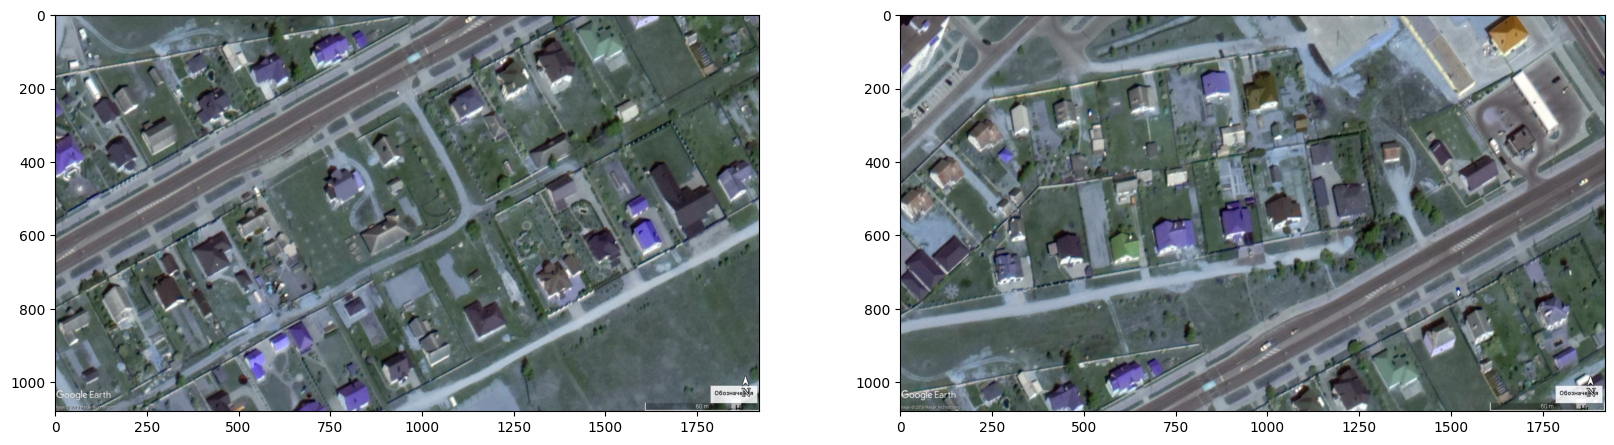

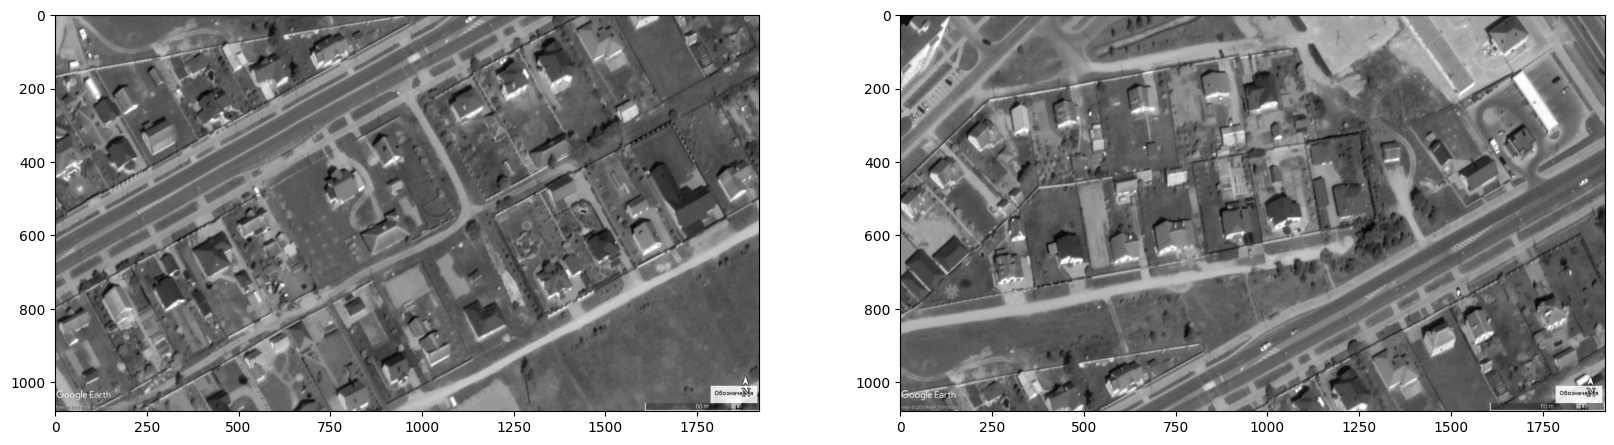

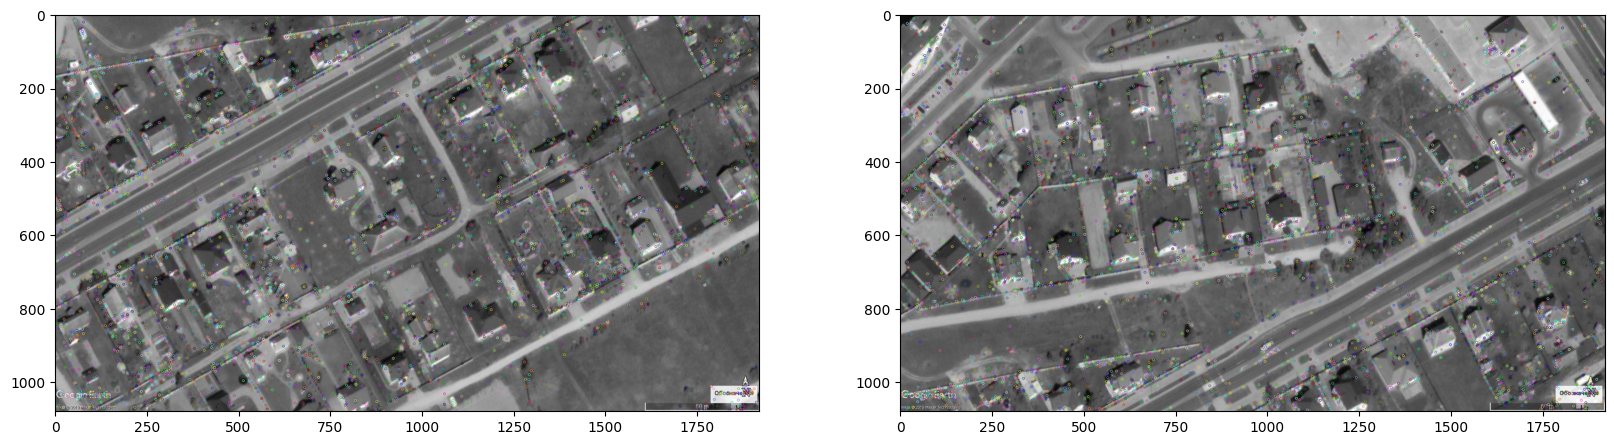

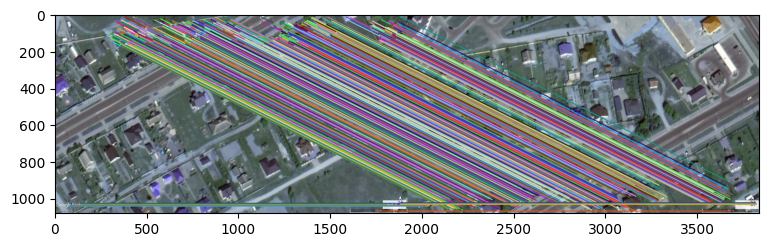

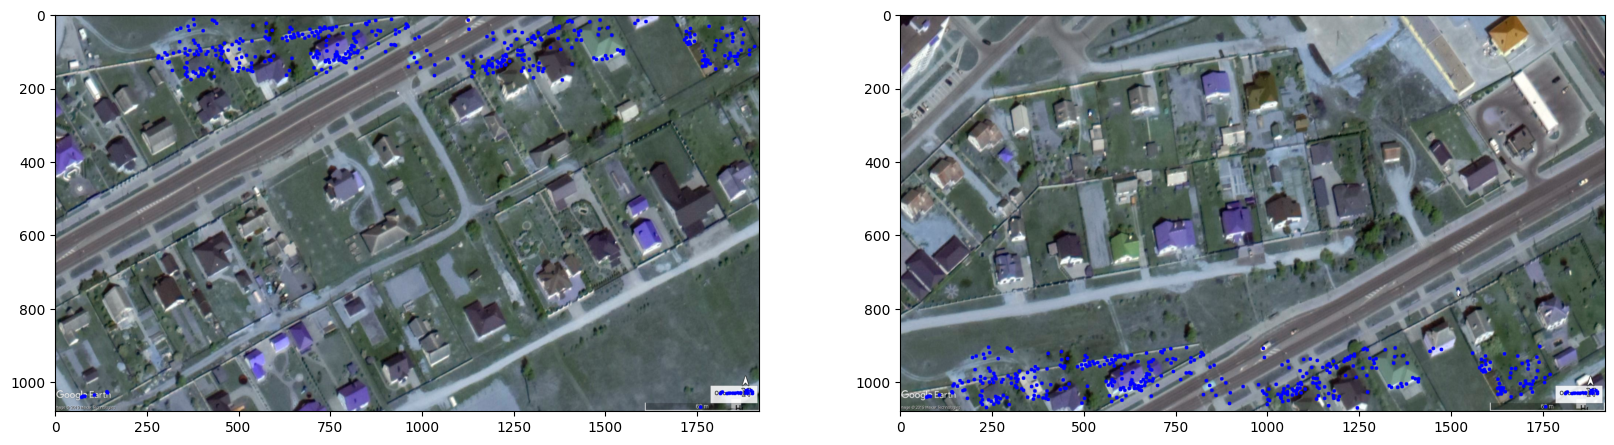

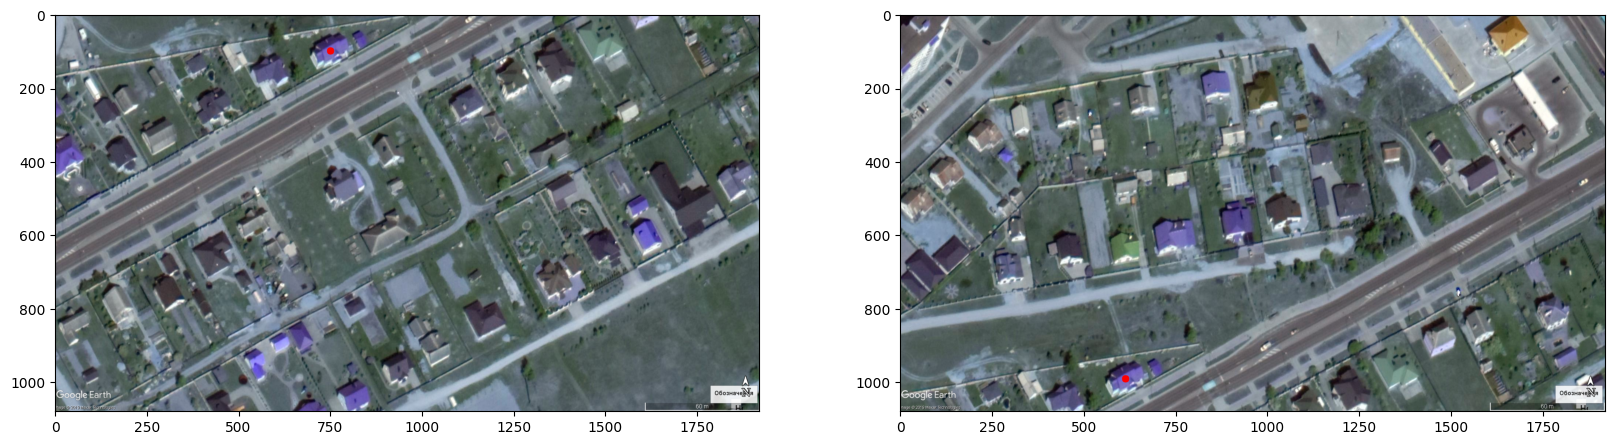

In [7]:
img1_path = 'photos/image_10.jpg'
img2_path = 'photos/image_11.jpg'

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
p1 = (750, 100, 1)

affine_matrix_3d = calculate_affine_matrix_3d(img1, img2)
p2 = calculate_point2(img1.copy(), img2.copy(), affine_matrix_3d, p1)


Раскладывам афинную матрицу на составляющие, затем собираем из составляющих, сравнивам сами матрицы и результат их работы по нахождению точки на втором изображении. 

In [12]:
# function to decompose 3D-matrix
def decompose_matrix(M):
    # translation matrix
    T = M[:2, 2:]

    # scale by OX, scale by OY, than scale matrix
    sx = np.sqrt(M[0, 0] ** 2 + M[1, 0] ** 2)
    sy = np.sqrt(M[0, 1] ** 2 + M[1, 1] ** 2)

    S = np.diag([sx, sy])

    # rotation angle by OZ
    R = M[:2, :2] / np.array([[sx, sx], [sy, sy]])
    thetaZ_rad = np.arctan2(R[1, 0], R[0, 0])
    thetaZ_deg = np.degrees(thetaZ_rad)

    # heave matrix
    H = (M[0, 0] * M[0, 1] + M[1, 0] * M[1, 1]) / (sx * sy)

    print('Rotation angle, deg:', thetaZ_deg)
    print('\nTranslation matrix:\n', T)
    print('\nScale matrix:\n', S)
    print('\nHeave: ', H, '\n')

    return S, T, R, thetaZ_deg, H


In [9]:
# function to compose affine 3D-matrix from rotation angle, translation and scale matrices, heave value
def recompose_matrix(thetaZ_deg: float, translation_matrix, scale_matrix, heave):
    thetaZ_rad = np.radians(thetaZ_deg)

    # create rotation matrix by OZ
    R = np.array([[np.cos(thetaZ_rad), -np.sin(thetaZ_rad), 0], 
                  [np.sin(thetaZ_rad), np.cos(thetaZ_rad), 0],
                  [0, 0, 1]])

    # create translation 3D-matrix
    T = np.array([[1, 0, translation_matrix[0, 0]], 
                  [0, 1, translation_matrix[1, 0]], 
                  [0, 0, 1]])

    # create scale 3D-matrix
    S = np.diag([scale_matrix[0, 0], scale_matrix[1, 1], 1])

    # create heave 3D-matrix
    H = np.array([[1, heave * scale_matrix[0, 0] / scale_matrix[1, 1], 0], 
                  [0, 1, 0], 
                  [0, 0, 1]])

    # return matices multiplication result
    return T @ R @ H @ S


In [14]:
print('INITIAL matrix:\n', affine_matrix_3d, '\n\nDECOMPOSE affine matrix:')

# get 3D affine matrix components
S, T, R, thetaZ_deg, H = decompose_matrix(affine_matrix_3d)

# create 3D-matrix from components
M_3d = recompose_matrix(thetaZ_deg, T, S, H)
print('RECOMPOSE affine matrix:\n', M_3d, '\n')

# compare recompose matrix with initial
is_close = np.allclose(affine_matrix_3d, M_3d)
print('Are initial and recompose affine matrices simillar?', is_close)


INITIAL matrix:
 [[ 1.00004449e+00  5.39871652e-04 -1.35654384e+02]
 [-2.75861988e-04  9.97683919e-01  8.92674106e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

DECOMPOSE affine matrix:
Rotation angle, deg: -0.01584241784948784

Translation matrix:
 [[-135.65438358]
 [ 892.67410631]]

Scale matrix:
 [[1.00004453 0.        ]
 [0.         0.99768407]]

Heave:  0.00026527517675918404 

RECOMPOSE affine matrix:
 [[ 1.00004449e+00  5.41148967e-04 -1.35654384e+02]
 [-2.76514662e-04  9.97683954e-01  8.92674106e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

Are initial and recompose affine matrices simillar? False


Как видно из результата метода numpy.allclose(), афинная матрица до разложения и матрица после обратного сложения не совпадают, однако по выводу верхней ячейки понятно, что вторая матрица близка к первой. Проверяем работу второй матрицы на задаче нахождения точки первого изображения на втором. Ниже красным выделена одна и та же точка на двух картинках. Следовательно, собранная афинная матрица работает приблизительно также.


Point in first image: (750, 100, 1) 
Point in second image: [614.43309975 992.2351157    1.        ]


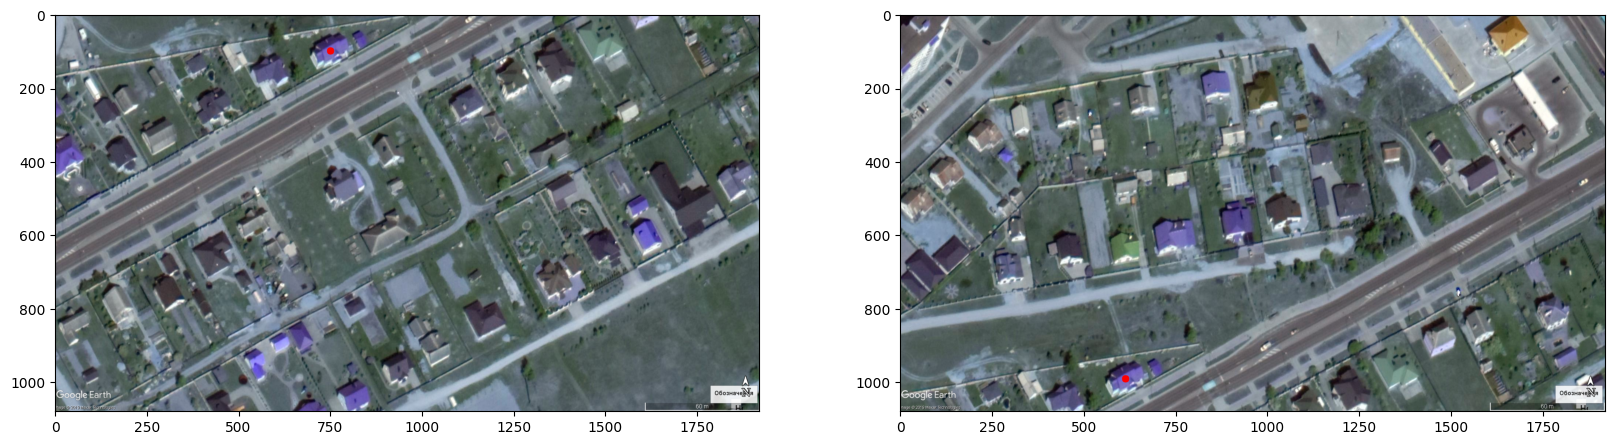

In [11]:
# calculate and visialize p1 point in second image based on recompose 3D affine matrix
p2_recompose = calculate_point2(img1, img2, M_3d, p1)


2) Взять любую видеопоследовательность (желательно вид сверху) - например, полет дрона. Можете скачать из интернета (https://www.youtube.com/@Vaska_pilot/videos) или взять что-то с работы.<br>
Зафиксировав точку (например, центр экрана) выполнить поиск данной точки на последнем кадре с использованием матрицы афинного преобразования 
(считая матрицу между кадрами вы всегда сможете понять где именно находится точка на изображении, а по отклонению самой точки вы можете определить точность самого алгоритма).<br>
Не берите 4к - долго считать, HD будет достаточно.<br>
Посчитать расстояние между точками и ошибку в пикселях.<br>
Попробуйте добавить шум к изображению, посмотрите, как меняется точность (положение точки). <br>
Добавьте фильтр к изображению для улучшения контрастности (любой, который найдете).<br>
Оцените, как влияет выбор метода определения матрицы афинного преобразования - например, estimateAffine2D и его аналоги (аналоги найдите самии).<br>
Оцените, как влияет выбор детектора/дескриптора особых точек на результат. Какой метод даст лучший и самый быстрый результат? 